# ViT Self-Attention <a id="top"></a>

---
## Table of Contents

* [Self-Attention Overview](#self_attention_overview)
    * [Process](#process)
    * [Pseudocode](#pseudocode)
* [Self-Attention Pipeline](#self_attention_pipeline)
    * [Imports](#imports)
    * [Mini-Example](#mini)
    * [Random Image](#image)
    * [Image with Patches](#patches)
        * [With cls token](#cls)
* [DINO Model](#dino)
    * [Helper Functions](#functions)
    * [Attention Run](#run)

# Self-Attention Overview<a class="anchor" id="self_attention_overview"></a>

Self-attention has ascended to the forefront of deep learning, demonstrating remarkable effectiveness in a multitude of domains, encompassing image processing as well. This innovative approach has revolutionized the field of computer vision, particularly with its integration into Vision Transformers (ViTs). ViTs leverage self-attention mechanisms either as a complete substitute for, or as a collaborative partner with, traditional convolutional layers. However, it's essential to acknowledge the trade-offs inherent to this technology. While self-attention boasts numerous advantages, it often necessitates a significant increase in the number of parameters and computational resources required, compared to its established counterpart, the Convolutional Neural Network (CNN).

## Process <a class="anchor" id="process"></a>

**1. Define parameters and initialize data:**

- **Image size, number of images, and patch size:** These define the input image and how it's divided into smaller patches.
- **Number of channels and dimensions:** These determine the complexity of the attention mechanism and the size of internal representations.
- **Heads:** Refers to the parallel attention mechanisms operating within the same layer of a neural network. Each "head" can be thought of as a separate attention mechanism, each capturing different relationships and dependencies within the input data. 

**2. Preprocess data:**

- **Add cls token:** CLS token is used similarly to NLP tasks but adapted for the context of images. It serves as a representation of the entire image, which is useful for tasks like image classification and can be leveraged for downstream tasks and fine-tuning.
- **Extract patches:** The image is divided into overlapping or non-overlapping patches based on the defined patch size.
- **Add positional encoding:** This step incorporates the position information of each patch into its representation, important for capturing long-range dependencies in sequences.

**3. Reshape and linear transformation:**

- **Reshape patches:** The patches are reshaped to a format suitable for further processing.
- **Linear transformation:** A linear layer transforms the patch representations into three sets of vectors: query (Q), key (K), and value (V). These vectors will be used to calculate attention scores.

**4. Calculate attention scores:**

- **Scaled dot product:** The dot product between Q and the transpose of K is calculated and scaled by the square root of dimension for stability.
- **Interpretation:** Higher scores indicate a stronger relationship between a specific patch (represented by Q) and another patch (represented by the corresponding row in K).

**5. Apply softmax and weighted sum:**

- **Softmax:** The attention scores are normalized using softmax, resulting in attention weights between 0 and 1.
- **Weighted sum:** The value vectors (V) are weighted by the attention weights, effectively emphasizing patches relevant to the current focus based on the query patch.
- **Interpretation:** The final output is a weighted combination of the value vectors, capturing the most relevant information from surrounding patches based on the query patch.

## Pseudocode <a class="anchor" id="pseudocode"></a>

This pseudocode provides a high-level overview of the logic behind self-attention, without focusing on specific programming language syntax. Remember, this is a simplified representation, and the actual implementation can vary depending on the chosen framework and specific application.

```
1. Define parameters and functions 

FUNCTION extract_patches(image, patch_size):
  # Divides image into patches and returns a tensor of patches

FUNCTION positional_encoding(patches):
  # Adds positional information to each patch and returns encoded patches

2. Preprocess data

patches = extract_patches(image, patch_size)
patches_with_pos = positional_encoding(patches.flatten())

3. Reshape and linear transformation

num_patches = patches_with_pos.shape[0]
patches_with_pos_reshaped = patches_with_pos.reshape(num_patches, -1)  # Flatten for linear layer

FUNCTION linear_qkv(x):
  # Linear transformation to generate Q, K, V vectors
  return Q, K, V

Q, K, V = linear_qkv(patches_with_pos_reshaped)

4. Calculate attention scores

d_k = dim // num_heads  # Dimension of Q, K, and V after splitting
scale = 1 / math.sqrt(d_k)  # Scaling factor

attention_scores = Q.dot(K.transpose()) * scale

5. Apply softmax and weighted sum

attention_weights = softmax(attention_scores, axis=-1)  # Softmax along the last dimension
output = attention_weights.dot(V)
```

# Self-Attention Pipeline <a class="anchor" id="self_attention_pipeline"></a>

## Imports <a class="anchor" id="imports"></a>

In [1]:
from argparse import Namespace
from dataclasses import dataclass, field
import math
import os
from pathlib import Path
import re
import requests
from typing import Dict, Union

from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models as torchvision_models
from torchvision import transforms as pth_transforms

from ai_tutorials import vision_transformer as vits

print(f'Torch version is: {torch.__version__}')
print(f'Is CUDA available: {torch.cuda.is_available()}')

Torch version is: 2.2.0a0+6a974be
Is CUDA available: True


## Mini-Example <a class="anchor" id="mini"></a>

Briefly introduce the concept of self-attention and its role in tasks like machine translation or sentiment analysis.
Mention that this code snippet demonstrates a simplified example of a single step within a self-attention mechanism.

In [2]:
# The softmax function is used to convert scores into probabilities, ensuring they sum to 1.
# I recommend using nn.functional.
def softmax(x, axis=-1):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

# Example concatenated embedding
concatenated_embedding = np.array([[1, 2, 3, 7, 8],
                                   [4, 5, 6, 9, 10]])

print("Example Concatenated Embedding:")
print(concatenated_embedding)
print(f"Shape of concatenated embedding: {concatenated_embedding.shape}")
print(f"Embedding dimension: {concatenated_embedding.shape[-1]}")

# Assuming the number of attention heads and other parameters
num_heads = 2
d_model = concatenated_embedding.shape[-1]  # Dimension of the concatenated embedding
print(f"Total embedding dimension (d_model): {d_model}")
d_k = d_v = d_model // num_heads
print(f"Dimension of keys and values (d_k and d_v): {d_k}")
print("-----")

# Generate Query, Key, and Value matrices
Q = concatenated_embedding.dot(np.random.rand(d_model, d_k))  # Query matrix
K = concatenated_embedding.dot(np.random.rand(d_model, d_k))  # Key matrix
V = concatenated_embedding.dot(np.random.rand(d_model, d_v))  # Value matrix
print(f"Q-{Q.shape}:\n{Q}\nK-{K.shape}:\n{K}\nV-{V.shape}:\n{V}")
print("-----")

# Calculate attention scores
attention_scores = np.matmul(Q, K.T) / np.sqrt(d_k)
print(f"Attention scores ({attention_scores.shape}):")
print(attention_scores)
print("-----")

# Apply softmax to obtain attention weights
attention_weights = softmax(attention_scores, axis=-1)
print(f"Attention weights ({attention_weights.shape}):")
print(attention_weights)
print("-----")

# Compute the weighted sum using attention weights
output = np.dot(attention_weights, V)
print(f"Output after weighted sum ({output.shape}):")
print(output)

Example Concatenated Embedding:
[[ 1  2  3  7  8]
 [ 4  5  6  9 10]]
Shape of concatenated embedding: (2, 5)
Embedding dimension: 5
Total embedding dimension (d_model): 5
Dimension of keys and values (d_k and d_v): 2
-----
Q-(2, 2):
[[12.0956319  16.88670474]
 [20.49672083 26.33395052]]
K-(2, 2):
[[15.8232543   8.00827565]
 [23.84011293 12.80672338]]
V-(2, 2):
[[14.44279779 11.53964531]
 [22.10736472 18.52654019]]
-----
Attention scores ((2, 2)):
[[230.95920911 356.82346731]
 [378.45370388 583.99649178]]
-----
Attention weights ((2, 2)):
[[2.17694368e-55 1.00000000e+00]
 [5.41877875e-90 1.00000000e+00]]
-----
Output after weighted sum ((2, 2)):
[[22.10736472 18.52654019]
 [22.10736472 18.52654019]]


## 64x64 Random Images and Positional Encoding <a class="anchor" id="image"></a>

#### Positional Encoding

Takes a 3D tensor embedding as input. The shape of the tensor is assumed to be `(batch_size, sequence_length, embedding_dimension)`.

For each position in the input sequence and for each dimension in the embedding space using a combination of sine and cosine functions with varying frequencies. These positional encodings are then added to the original embeddings to enrich them with positional information and understand the sequential order of tokens in the input data.

**Sequence Length and Channel Dimension:**
- `seq_len = embedding.shape[1]`: Determines the length of the sequence, which is the number of tokens in the input.
- `channel_dim = embedding.shape[-1]`: Represents the dimensionality of the embedding vectors. It's typically the depth of the embedding space.

**Creating Positional Encoding Matrix:**
- `pos_enc = np.zeros((seq_len, channel_dim))`: Initializes a matrix of zeros with dimensions `(seq_len, channel_dim)`. This matrix will hold the positional encoding values.
- Positional encoding is computed using a combination of sine and cosine functions of different frequencies.

**Positional Encoding Computation:**
- Two nested loops iterate over each position in the sequence (`pos`) and each dimension of the embedding (`i`).
- Inside the loop:
    - `pos_enc[pos, i] = math.sin(pos / (10000 ** ((2 * i) // channel_dim)))`: Computes the sine of a value based on the position `pos`, the dimension `i`, and a scaling factor (`10000`) raised to a power determined by the dimension index.
    - `pos_enc[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) // channel_dim)))`: Computes the cosine in a similar manner to the sine but with an offset of 1 in the dimension index.
Handling Odd Dimensionalities:

The if statement `if i + 1 < channel_dim:` ensures that the computation of cosine is only done when there's an additional dimension available. This is because cosine is computed for `i+1`.

**Return Statement:**
- `return embedding + pos_enc`: Adds the positional encoding matrix to the input embeddings. This operation effectively combines the positional information with the original embeddings.

In [3]:
def positional_encoding(embedding):
    """Add positional encoding to input embeddings."""
    seq_len = embedding.size(1)
    channel_dim = embedding.size(-1)
    pos_enc = torch.zeros(seq_len, channel_dim)
    for pos in range(seq_len):
        for i in range(0, channel_dim, 2):
            pos_enc[pos, i] = math.sin(pos / (10000 ** ((2 * i) / channel_dim)))
            if i + 1 < channel_dim:
                pos_enc[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1)) / channel_dim)))
    pos_enc = pos_enc.unsqueeze(0)  # Adding batch dimension
    pos_enc = pos_enc.to(embedding.device)  # Move to same device as embedding
    return embedding + pos_enc

In [4]:
image_size = 64 # High image size will not work on small GPU
num_images = 1

# Parameters
num_channels = 3  # 3 channels for RGB images
num_heads = 2
dim = image_size * image_size * num_channels  # Dimension of the input (total number of features)
print(f"dim: {dim}")
d_k = d_v = dim // num_heads
print(f"d_k and d_v: {d_k}")
print("-----")

images = torch.rand(num_images, image_size, image_size, num_channels)
print(f"Images shape: {images.shape}") # 2 images, 64 by 64, 3 channels
print("-----")

# Reshape images to have a sequence length of image_size * image_size
images_flattened = images.view(num_images, -1, num_channels)
print(f"Images reshaped: {images_flattened.shape}")
print(images_flattened)
print("-----")

# Add positional encoding
images_with_pos = positional_encoding(images_flattened)
print(f"Patches with positional: {images_with_pos.shape}")

dim: 12288
d_k and d_v: 6144
-----
Images shape: torch.Size([1, 64, 64, 3])
-----
Images reshaped: torch.Size([1, 4096, 3])
tensor([[[0.9947, 0.5539, 0.8108],
         [0.0377, 0.0546, 0.8352],
         [0.3141, 0.8690, 0.0290],
         ...,
         [0.9610, 0.0849, 0.0750],
         [0.1619, 0.3688, 0.2746],
         [0.9991, 0.4480, 0.4793]]])
-----
Patches with positional: torch.Size([1, 4096, 3])


In [5]:
# Linear transformation to generate Q, K, and V matrices
linear_qkv = nn.Linear(num_channels, d_k * 3, bias=False) # Linear(in_features=3, out_features=18432, bias=False)
print(linear_qkv)
qkv = linear_qkv(images_with_pos)
qkv = qkv.view(num_images, -1, 3, num_heads, d_k // num_heads).permute(2, 0, 3, 1, 4)
Q, K, V = qkv[0], qkv[1], qkv[2]
print(f"Q-{Q.shape}:\n{Q}\nK-{K.shape}:\n{K}\nV-{V.shape}:\n{V}")
print("-----")

# Calculate attention scores
scale = d_k ** -0.5
attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * scale
print(f"Attention scores ({attention_scores.shape}):")
print(attention_scores)
print("-----")

# Apply softmax to obtain attention weights
attention_weights = F.softmax(attention_scores, dim=-1)
print(f"Attention weights ({attention_weights.shape}):")
print(attention_weights)
print("-----")

# Compute the weighted sum using attention weights
output = torch.matmul(attention_weights, V)
print(f"Output after weighted sum ({output.shape}):")
print(output)

Linear(in_features=3, out_features=18432, bias=False)
Q-torch.Size([1, 2, 4096, 3072]):
tensor([[[[ 8.3967e-01,  7.3438e-01, -5.1865e-01,  ...,  1.2160e+00,
            3.8747e-01, -4.7358e-01],
          [ 6.0810e-01,  5.4609e-01, -3.9076e-01,  ...,  8.6376e-01,
            3.3843e-01, -3.9799e-01],
          [ 8.5214e-01,  3.5176e-01, -4.1292e-01,  ...,  1.6961e+00,
           -8.8411e-02, -2.0163e-01],
          ...,
          [-4.0269e-01, -1.0978e+00,  3.6366e-01,  ...,  2.9067e-01,
           -7.3253e-01,  3.4880e-01],
          [-1.5614e-01,  9.1959e-02,  3.1407e-02,  ..., -4.9439e-01,
            2.0458e-01, -7.0545e-02],
          [-9.8858e-02,  7.3671e-02,  1.2786e-03,  ..., -3.3137e-01,
            2.0021e-01, -1.1321e-01]],

         [[-3.4624e-01, -7.2965e-01,  3.0136e-02,  ...,  1.1007e+00,
            4.2134e-01, -1.2684e+00],
          [-8.0799e-02, -4.8435e-01,  1.4109e-01,  ...,  8.4870e-01,
            3.1767e-01, -1.1156e+00],
          [-7.5364e-01, -1.2311e+00, -3

## Image with patches example <a class="anchor" id="patches"></a>

#### Extract Patches from image

The function takes two parameters: images, which is assumed to be a list of images represented as numpy arrays, and patch_size, which is an integer indicating the size of the patches to be extracted. It then iterates over each image, divides it into non-overlapping patches of the specified size, flattens each patch into a 1D vector, and appends it to a list. Finally, it converts this list of patches into a numpy array and returns it.

**Initialization of Patch List:**
- `patches = []`: Initializes an empty list to store the patches extracted from the images.

**Iterating Over Each Image:**
- `for image in images:`: Loops through each image in the list of images.

**Extracting Patches:**
- Nested loops iterate over each image to extract patches:
    - `for i in range(0, image.shape[0] - patch_size + 1, patch_size)`: Iterates over the rows of the image with a step size of `patch_size`. The loop ensures that patches are extracted without overlapping vertically.
    - `for j in range(0, image.shape[1] - patch_size + 1, patch_size)`: Iterates over the columns of the image with a step size of `patch_size`. Similar to the previous loop, it ensures non-overlapping patches horizontally.
    - Inside these loops, a patch is extracted from the image using slicing:
        - `patch = image[i:i+patch_size, j:j+patch_size, :]`: Extracts a patch of size `patch_size x patch_size` from the image.
        - `patch.flatten()`: Flattens the patch into a 1D array. This is done to convert the 2D patch into a 1D vector so that it can be easily appended to the list of patches.

**Appending Patches to List:**
- `patches.append(patch.flatten())`: Appends the flattened patch to the list of patches.

**Returning Patches:**
- `return np.array(patches)`: This final array contains all the patches extracted from the input images.

In [6]:
# Manually extracts patches using loops
def extract_patches(image, patch_size, dim, cls_token=None):
    patches = []
    if cls_token is not None:
        patches.append(cls_token)
    for i in range(0, image.shape[1] - patch_size + 1, patch_size):
        for j in range(0, image.shape[2] - patch_size + 1, patch_size):
            patch = image[:, i:i+patch_size, j:j+patch_size, :]
            patches.append(patch.reshape(-1, dim))
    return torch.cat(patches, dim=0)

# Using Conv2d to extract patches in a more optimized and concise manner
# def extract_patches(image, patch_size, dim, cls_token=None):
#     patches = []
#     if cls_token is not None:
#         patches.append(cls_token)
#     batch_size, height, width, channels = image.size()
#     conv = nn.Conv2d(in_channels=channels, out_channels=dim, kernel_size=patch_size, stride=patch_size, bias=False)
#     with torch.no_grad():
#         image_patches = conv(image.permute(0, 3, 1, 2))  # Permute to [batch_size, channels, height, width] for Conv2d
#         patches.append(image_patches.permute(0, 2, 3, 1).reshape(-1, dim))
#     return torch.cat(patches, dim=0)

In [7]:
# Example images (for demonstration, you would use your actual images here)
image_w = 500
image_h = 375

# Parameters
num_channels = 3 # Assuming RGB images
num_heads = 8
patch_size = 16 # Patch size (similar to DINO)
dim = num_channels * patch_size * patch_size  # Dimension of each patch
print(f"dim: {dim}")
d_k = d_v = dim // num_heads
print(f"d_k and d_v: {d_k}")
print("-----")

# image = np.random.rand(1, image_h, image_w, num_channels)
image = torch.rand(1, image_h, image_w, num_channels)
# (batch size, H by W, 3 channels)
print(f"Image shape: {image.shape}")

dim: 768
d_k and d_v: 96
-----
Image shape: torch.Size([1, 375, 500, 3])


In [8]:
# Extract patches from the input image
image_patches = extract_patches(image, patch_size, dim) # Pass a list containing the single image
# (patches extracted, flatten dim of each patch)
print(f"Patches shape: {image_patches.shape}")
print("-----")

# Apply positional encoding to each patch individually
num_patches = image_patches.shape[0]
pos_enc = positional_encoding(image_patches.view(num_patches, -1, num_channels))
# (patches extracted, pos enc elements, channels)
print(f"Patches with positional: {pos_enc.shape}")
print("-----")

# Concat positional encoding with image_patches
image_patches_with_pos = pos_enc.reshape(1, -1, dim)
# (batch size, patches extracted, flatten dim (channelsxpos_enc))
print(f"Patches with positional reshaped: {image_patches_with_pos.shape}")

Patches shape: torch.Size([713, 768])
-----
Patches with positional: torch.Size([713, 256, 3])
-----
Patches with positional reshaped: torch.Size([1, 713, 768])


In [9]:
# Linear transformation to generate Q, K, and V matrices
linear_qkv = nn.Linear(dim, d_k * 3, bias=False)
print(linear_qkv)
qkv = linear_qkv(image_patches_with_pos.float())
qkv = qkv.reshape(1, -1, 3, num_heads, d_k // num_heads).permute(2, 0, 3, 1, 4)
Q, K, V = qkv[0], qkv[1], qkv[2]
# (batch size, # of attention heads, patches extracted, dim of each patch (d_k//8))
print(f"Q-{Q.shape}:\n{Q}\nK-{K.shape}:\n{K}\nV-{V.shape}:\n{V}")
print("-----")

# Calculate attention scores
scale = d_k ** -0.5
attention_scores = (torch.matmul(Q, K.transpose(-2, -1))) * scale
# (batch size, # of attention heads, # of patches for Q, # of patches for K)
# Represents the attention score between a patch in the Q matrix and a patch in the K matrix.
print(f"Attention scores ({attention_scores.shape}):")
print(attention_scores)
print("-----")

# Apply softmax to obtain attention weights
attention_weights = F.softmax(attention_scores, dim=-1)
# (batch size, # of attention heads, # of patches for Q, # of patches for K)
# Represents the attention weight between a patch in the Q matrix and a patch in the K matrix 
# after applying the softmax function.
print(f"Attention weights ({attention_weights.shape}):")
print(attention_weights)
print("-----")

# Compute the weighted sum using attention weights
output = torch.matmul(attention_weights, V)
# (batch size, # of attention heads, patches extracted, dim of each patch (d_k//8))
# Represents the output of the weighted sum operation for each patch across all attention heads.
print(f"Output after weighted sum ({output.shape}):")
print(output)

Linear(in_features=768, out_features=288, bias=False)
Q-torch.Size([1, 8, 713, 12]):
tensor([[[[-6.9446e-01,  7.2709e-03, -7.0991e-01,  ..., -3.6297e-01,
           -6.6223e-01, -6.0551e-01],
          [-4.3834e-01,  6.5802e-03, -3.3018e-01,  ..., -4.5028e-01,
           -7.2861e-01, -4.8791e-01],
          [-5.5867e-01, -2.3063e-01, -4.4972e-01,  ..., -2.3251e-01,
           -4.6247e-01, -4.4910e-01],
          ...,
          [-8.8332e-01, -1.0123e-01, -5.4259e-01,  ...,  5.8761e-04,
           -8.9878e-01, -3.6742e-01],
          [-3.8690e-01,  8.4805e-02, -3.5116e-01,  ..., -1.5653e-01,
           -6.9528e-01, -5.4164e-01],
          [-7.8323e-01, -2.7928e-01, -7.2173e-01,  ..., -1.9554e-01,
           -5.9869e-01, -7.0975e-01]],

         [[ 2.9422e-01, -1.0000e-02,  1.1585e+00,  ...,  9.2487e-01,
           -4.6152e-01, -3.4199e-01],
          [ 1.4412e-01, -1.4485e-01,  8.1130e-01,  ...,  1.0658e+00,
           -7.4726e-01, -4.3532e-01],
          [ 2.2258e-01, -1.1038e-01,  9.40

### With cls_token <a class="anchor" id="cls"></a>

In [10]:
cls_token = torch.randn(1, dim)  # Generating random cls_token
image_patches = extract_patches(image, patch_size, dim, cls_token=cls_token)
# (patches extracted + 1 cls_token, flatten dim of each patch)
print(f"Patches shape: {image_patches.shape}")
print("-----")

# Apply positional encoding to each patch individually
num_patches = image_patches.shape[0]
pos_enc = positional_encoding(image_patches.view(num_patches, -1, num_channels))
# (patches extracted w/ cls_token, pos enc elements, channels)
print(f"Patches with positional: {pos_enc.shape}")
print("-----")

# Concat positional encoding with image_patches
image_patches_with_pos = pos_enc.reshape(1, -1, dim)
# (batch size, patches extracted w/ cls_token, flatten dim (channelsxpos_enc))
print(f"Patches with positional reshaped: {image_patches_with_pos.shape}")

Patches shape: torch.Size([714, 768])
-----
Patches with positional: torch.Size([714, 256, 3])
-----
Patches with positional reshaped: torch.Size([1, 714, 768])


In [11]:
# Linear transformation to generate Q, K, and V matrices
linear_qkv = nn.Linear(dim, d_k * 3, bias=False)
print(linear_qkv)
qkv = linear_qkv(image_patches_with_pos.float())
qkv = qkv.reshape(1, -1, 3, num_heads, d_k // num_heads).permute(2, 0, 3, 1, 4)
Q, K, V = qkv[0], qkv[1], qkv[2]
# (batch size, # of attention heads, patches extracted w/ cls_token, dim of each patch (d_k//8))
print(f"Q-{Q.shape}:\n{Q}\nK-{K.shape}:\n{K}\nV-{V.shape}:\n{V}")
print("-----")

# Calculate attention scores
scale = d_k ** -0.5
attention_scores = (torch.matmul(Q, K.transpose(-2, -1))) * scale
# (batch size, # of attention heads, # of patches for Q, # of patches for K)
# Represents the attention score between a patch in the Q matrix and a patch in the K matrix.
print(f"Attention scores ({attention_scores.shape}):")
print(attention_scores)
print("-----")

# Apply softmax to obtain attention weights
attention_weights = F.softmax(attention_scores, dim=-1)
# (batch size, # of attention heads, # of patches for Q, # of patches for K)
# Represents the attention weight between a patch in the Q matrix and a patch in the K matrix 
# after applying the softmax function.
print(f"Attention weights ({attention_weights.shape}):")
print(attention_weights)
print("-----")

# Compute the weighted sum using attention weights
output = torch.matmul(attention_weights, V)
# (batch size, # of attention heads, patches extracted w/ cls_token, dim of each patch (d_k//8))
# Represents the output of the weighted sum operation for each patch across all attention heads.
print(f"Output after weighted sum ({output.shape}):")
print(output)

Linear(in_features=768, out_features=288, bias=False)
Q-torch.Size([1, 8, 714, 12]):
tensor([[[[ 0.9812, -0.9614,  1.0869,  ...,  0.5225,  0.0073, -0.8730],
          [ 0.5799, -0.5732,  0.6396,  ...,  0.3946,  0.0421, -0.8783],
          [ 0.4856, -0.5262,  0.6222,  ...,  0.7052,  0.4174, -0.7587],
          ...,
          [ 0.2463, -0.8947,  0.7985,  ...,  0.1694,  0.0520, -0.7431],
          [ 0.4475, -0.4921,  0.6220,  ...,  0.2855,  0.1368, -0.7103],
          [ 0.4125, -0.7829,  0.8298,  ...,  0.5293,  0.1002, -0.7792]],

         [[-0.0326, -0.6305,  0.9869,  ...,  0.8786,  0.9370, -0.3511],
          [-0.9423, -0.1890,  0.0319,  ...,  0.6571,  1.0802, -0.3505],
          [-0.6022,  0.0691,  0.1064,  ...,  0.7857,  0.9537, -0.4475],
          ...,
          [-0.3524, -0.1299,  0.2065,  ...,  0.4812,  1.0528, -0.6505],
          [-0.2933,  0.0026,  0.0666,  ...,  0.7972,  0.9449, -0.3702],
          [-0.5195, -0.3421, -0.0934,  ...,  0.6727,  0.6820, -0.4137]],

         [[-0.576

# DINO Model <a class="anchor" id="dino"></a>

In [12]:
arch = "vit_small" # num_heads = 6
checkpoint_key = "teacher"
patch_size = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
if arch in torchvision_models.__dict__.keys():
    model = (torchvision_models.__dict__[arch](
        num_classes=0))
    model.fc = nn.Identity()
else:
    model = vits.__dict__[arch](
        patch_size=patch_size, num_classes=0)

url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"

state_dict = torch.hub.load_state_dict_from_url(
    url="https://dl.fbaipublicfiles.com/dino/" + url)
model.load_state_dict(state_dict, strict=True)

for p in model.parameters():
    p.requires_grad = False

model.cuda()
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

## Helper Functions <a class="anchor" id="functions"></a>

### Transform

In [14]:
transform = pth_transforms.Compose([
    # pth_transforms.Resize((480, 480)),
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

### Get Attention

In [15]:
def get_attention(image, patch_size):
    # img_path = f"{path}/{img_name}"
    # img = Image.open(img_path).convert('RGB')
    img = image
    print(f"Original Image Size: {img.size}")

    img = transform(img)
    print(f"Transformed Image Size: {img.shape}")
        
    # Make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)
    print(f"Image by Patch Size: {img.shape}")
    
    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    y, attentions, test_scores, test_weights = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # Number of heads

    # Keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=16, mode="nearest")[0].cpu().numpy()
    
    return y, attentions, test_scores, test_weights

### Plot Attentions Function

In [16]:
def plot_img(img, img_per_col = 3, ):
    num_images = len(img)
    num_images

    nrow = num_images // img_per_col
    ncol = num_images // nrow

    fig, axes = plt.subplots(
        nrow, ncol,
        gridspec_kw=dict(wspace=0.05, hspace=0.05,
                         top=1. - 0.5 / (nrow + 1), bottom=0.5 / (nrow + 1),
                         left=0.5 / (ncol + 1), right=1 - 0.5 / (ncol + 1)),
        figsize=(ncol + 10, nrow + 10)
    )

    for i, image in enumerate(img):
        ax = axes[i // ncol, i % ncol]
        ax.imshow(image)
        ax.axis("off")

    plt.show()

## Attention Run <a class="anchor" id="run"></a>

### Variables

In [17]:
# full_path = "/usr/src/ai_tutorials/data/coco_2017/val2017"
# img_name = "000000000139.jpg"
# img = Image.open(full_path + '/' + img_name)

url = "https://www.gamespot.com/a/uploads/scale_super/1561/15611758/3252639-transformers-age-of-extinction_95e719.jpg"
img = Image.open(requests.get(url, stream=True).raw)

### Display image

IMG SHAPE: (1280, 781)


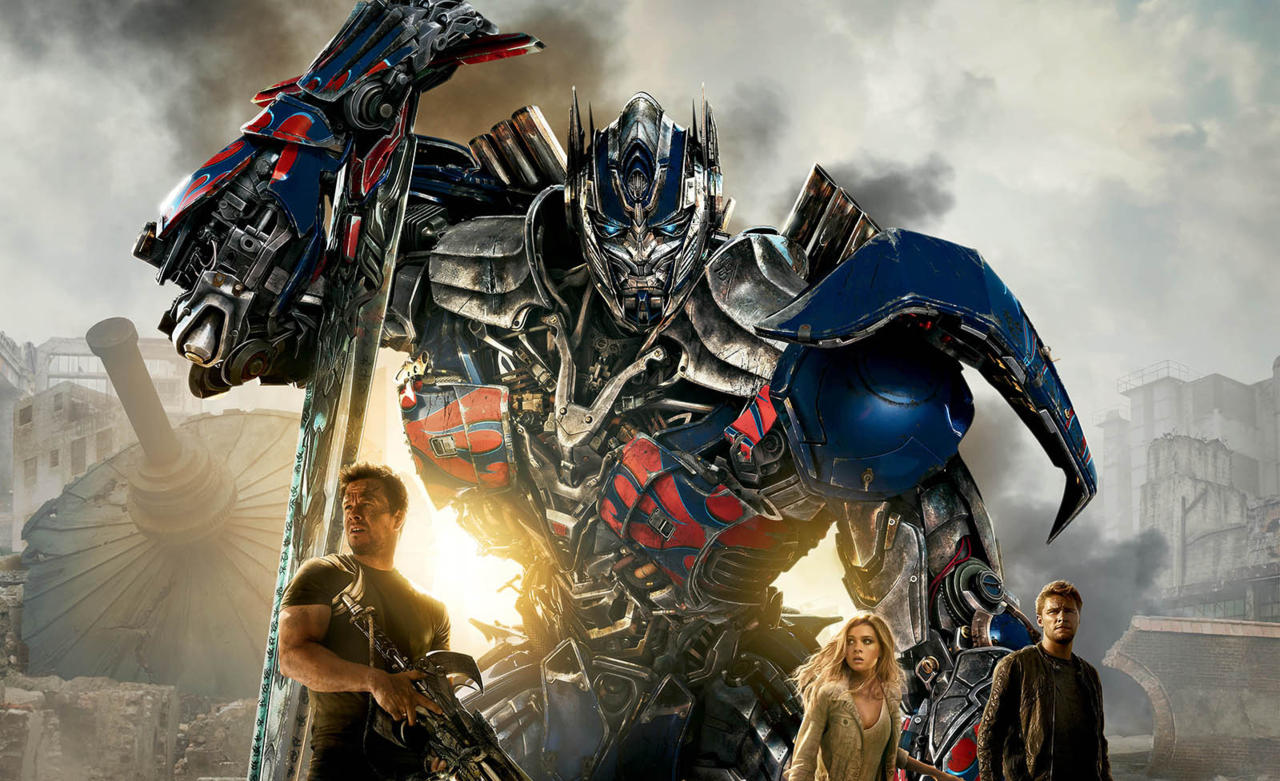

In [18]:
print(f"IMG SHAPE: {img.size}")
display(img)

### Get Attention

In [19]:
y, img_attentions, scores, weights = get_attention(image=img, patch_size=patch_size)

Original Image Size: (1280, 781)
Transformed Image Size: torch.Size([3, 781, 1280])
Image by Patch Size: torch.Size([1, 3, 768, 1280])

X SELF-ATTENION INPUT SIZE: torch.Size([1, 3, 768, 1280])

X BEFORE PREPARE TOKEN SIZE: torch.Size([1, 3, 768, 1280])
AFTER PATCH EMBED: torch.Size([1, 3840, 384])
CLS TOKENS: torch.Size([1, 1, 384])
AFTER CLS TOKENS CONCAT: torch.Size([1, 3841, 384])
AFTER INTERPOLATE POS ENCODING: torch.Size([1, 3841, 384])

ATTENTION SCORES: torch.Size([1, 6, 3841, 3841])
tensor([[4.0817, 2.2427, 2.2291, 2.2370, 2.1718],
        [5.5717, 3.2151, 3.2159, 3.2344, 3.1445],
        [5.5907, 3.2400, 3.2666, 3.2681, 3.1762],
        [5.6181, 3.2727, 3.2785, 3.3198, 3.2122],
        [5.5839, 3.2284, 3.2349, 3.2582, 3.1680]], device='cuda:0')

ATTENTION WEIGHTS (SOFTMAX): torch.Size([1, 6, 3841, 3841])
tensor([[0.0033, 0.0005, 0.0005, 0.0005, 0.0005],
        [0.0069, 0.0007, 0.0007, 0.0007, 0.0006],
        [0.0068, 0.0006, 0.0007, 0.0007, 0.0006],
        [0.0066, 0.0006,

### Confirming Scores and Weights

In [20]:
type(img_attentions), img_attentions.shape

(numpy.ndarray, (6, 768, 1280))

In [21]:
type(y), y.shape

(torch.Tensor, torch.Size([1, 3841, 384]))

In [22]:
scores.shape, weights.shape

(torch.Size([1, 6, 3841, 3841]), torch.Size([1, 6, 3841, 3841]))

In [23]:
first_scores = scores[0][0][:5][:5]
first_scores

tensor([[ 3.3043, -3.0851, -2.6143,  ..., -1.8823, -2.3760, -2.2470],
        [ 2.8830, -1.0532, -0.5767,  ..., -1.7211, -1.9319, -1.8633],
        [ 2.6830, -0.9542, -0.4661,  ..., -1.6760, -1.8514, -1.7507],
        [ 2.6278, -1.0485, -0.5682,  ..., -1.6760, -1.8118, -1.7877],
        [ 2.7441, -1.0552, -0.5779,  ..., -1.6385, -1.8099, -1.7430]],
       device='cuda:0')

In [24]:
first_weights = weights[0][0][:5][:5]
first_weights

tensor([[1.2802e-02, 2.1496e-05, 3.4423e-05,  ..., 7.1571e-05, 4.3682e-05,
         4.9698e-05],
        [8.6641e-03, 1.6914e-04, 2.7241e-04,  ..., 8.6735e-05, 7.0253e-05,
         7.5235e-05],
        [6.8112e-03, 1.7932e-04, 2.9215e-04,  ..., 8.7124e-05, 7.3108e-05,
         8.0851e-05],
        [6.5281e-03, 1.6527e-04, 2.6718e-04,  ..., 8.8240e-05, 7.7036e-05,
         7.8921e-05],
        [7.2918e-03, 1.6323e-04, 2.6310e-04,  ..., 9.1090e-05, 7.6744e-05,
         8.2055e-05]], device='cuda:0')

In [25]:
# Compute softmax along the last dimension (dim=1)
attn_weights = first_scores.softmax(dim=-1)
print(attn_weights)

tensor([[1.2802e-02, 2.1496e-05, 3.4423e-05,  ..., 7.1571e-05, 4.3682e-05,
         4.9698e-05],
        [8.6641e-03, 1.6914e-04, 2.7241e-04,  ..., 8.6735e-05, 7.0253e-05,
         7.5235e-05],
        [6.8112e-03, 1.7932e-04, 2.9215e-04,  ..., 8.7124e-05, 7.3108e-05,
         8.0851e-05],
        [6.5281e-03, 1.6527e-04, 2.6718e-04,  ..., 8.8240e-05, 7.7036e-05,
         7.8921e-05],
        [7.2918e-03, 1.6323e-04, 2.6310e-04,  ..., 9.1090e-05, 7.6744e-05,
         8.2055e-05]], device='cuda:0')


In [26]:
# if True, attn_weights, the softmax of first score, is the same as first_weight
print(torch.allclose(first_weights, attn_weights))

True


### Plot attentions

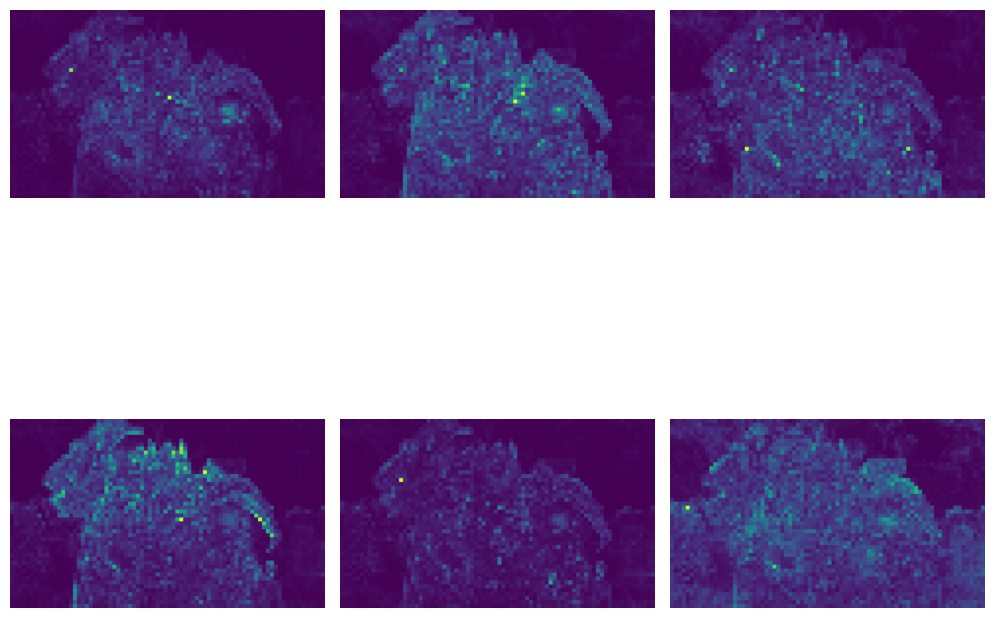

In [27]:
plot_img(img=img_attentions)

**[Go to Top](#top)**